##**TASK-15**

In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("online_retail_II.csv")

# Remove rows with missing CustomerID
df = df.dropna(subset=["Customer ID"])

# Remove cancelled invoices (Invoice starts with 'C')
df = df[~df["Invoice"].astype(str).str.startswith("C")]

# Remove negative or zero quantity
df = df[df["Quantity"] > 0]

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [2]:
# Convert to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df.dtypes


Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [3]:
# Create TotalAmount column
df["TotalAmount"] = df["Quantity"] * df["Price"]


In [4]:
# Set reference date as one day after last invoice date
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Create RFM table
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "Invoice": "nunique",
    "TotalAmount": "sum"
})

# Rename columns
rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [5]:
# Recency score (lower recency = better)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])

# Frequency score
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])

# Monetary score
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])


In [6]:
# Convert scores to string
rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

# Segment logic
def segment_customer(row):
    if row["RFM_Score"] == "444":
        return "Champions"
    elif row["R_Score"] == 4:
        return "Loyal Customers"
    elif row["R_Score"] <= 2:
        return "At Risk"
    else:
        return "Potential"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
Customer ID,,,,,,,,
12346.0,326,12,77556.46,2,4,4,244,At Risk
12347.0,2,8,5633.32,4,4,4,444,Champions
12348.0,75,5,2019.40,3,3,3,333,Potential
12349.0,19,4,4428.69,4,3,4,434,Loyal Customers
12350.0,310,1,334.40,2,1,1,211,At Risk


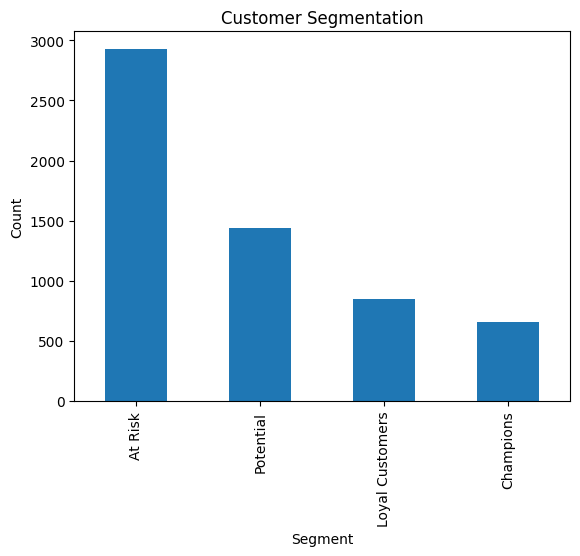

In [7]:
import matplotlib.pyplot as plt

segment_counts = rfm["Segment"].value_counts()

plt.figure()
segment_counts.plot(kind="bar")
plt.title("Customer Segmentation")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.show()


In [8]:
rfm.to_csv("rfm_segments.csv")


In [9]:
with open("segment_actions.txt", "w") as f:
    f.write("Champions:\n- Offer exclusive rewards\n- Early product access\n- Referral programs\n\n")
    f.write("Loyal Customers:\n- Upsell premium products\n- Loyalty points\n- Personalized offers\n\n")
    f.write("At Risk:\n- Send re-engagement emails\n- Discount coupons\n- Feedback surveys\n\n")
    f.write("Potential:\n- Targeted promotions\n- Onboarding campaigns\n- Email marketing\n")


##**INTERVIEW QUESTIONS**

## 1. What is RFM and where is it used?
    RFM is a customer segmentation technique based on Recency, Frequency, and Monetary value. It is widely used in marketing analytics to identify high-     value customers and design targeted campaigns.

## 2. How do you define Recency in RFM?
     Recency is the number of days since a customer’s last purchase. Lower recency means the customer is more recently active.

## 3. Why use quantile binning in segmentation?
    Quantile binning ensures customers are evenly distributed across scoring groups, making segmentation balanced and statistically meaningful.

## 4. What actions can be taken for “At Risk” customers?
     Send re-engagement campaigns
     Provide limited-time discounts
     Offer personalized communication

## 5. How do you validate segmentation usefulness?
     Check revenue contribution per segment
     Compare repeat purchase rates
     Track campaign conversion performance
     Monitor retention uplift after targeted actions